In [1]:
import os
import cv2
import numpy as np

from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [2]:
# load dataset
# in that method, we use the dataset which was processed by team member
# so the image has beed classed to three different folder: overall, mono,poly. And each folder has three subfolder: train, test, valid 
def load_dataset(data_path):
    data = {'train': [], 'test': [], 'valid': []}
    labels = {'train': [], 'test': [], 'valid': []}
    for subset in data.keys():
        subset_path = os.path.join(data_path, subset)
        for class_label in os.listdir(subset_path):
            class_path = os.path.join(subset_path, class_label)
            if os.path.isdir(class_path):  # 检查是否是目录
                for image_name in os.listdir(class_path):
                    image_path = os.path.join(class_path, image_name)
                    if os.path.isfile(image_path):  # 检查是否是文件
                        image = cv2.imread(image_path)
                        data[subset].append(image)
                        labels[subset].append(class_label)

    return data, labels

data_path = 'overall' 
data, labels = load_dataset(data_path)

In [3]:
# Extracting SIFT Features and Descriptors
sift = cv2.SIFT_create()
def extract_sift_features(images):
    descriptors = []
    for image in images:
        kp, des = sift.detectAndCompute(image, None)
        if des is not None:
            descriptors.extend(des)
    return descriptors

train_descriptors = extract_sift_features(data['train'])

In [4]:
# employing a bag of visual words model
k = 120 
kmeans = KMeans(n_clusters=k, random_state=0)

# ensure all training descriptors are converted to float32 type and merge them into a 2D array
train_descriptors_float32 = np.vstack([d.astype(np.float32) for d in train_descriptors])

# train KMeans model
kmeans.fit(train_descriptors_float32)


/Users/lorraine.gao/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=120, random_state=0)

In [5]:
# Feature Vectorization 
def images_to_feature_vectors(images, kmeans):
    feature_vectors = []
    for image in images:
        kp, des = sift.detectAndCompute(image, None)
        if des is not None:
            words = kmeans.predict(des)
            img_feature = np.bincount(words, minlength=kmeans.n_clusters)
            feature_vectors.append(img_feature)
        else:
            feature_vectors.append(np.zeros(kmeans.n_clusters))
    return feature_vectors


train_feature_vectors = images_to_feature_vectors(data['train'], kmeans)
valid_feature_vectors = images_to_feature_vectors(data['valid'], kmeans)
test_feature_vectors = images_to_feature_vectors(data['test'], kmeans)


In [6]:
# Feature Normalization
scaler = StandardScaler().fit(train_feature_vectors)
train_feature_vectors = scaler.transform(train_feature_vectors)
valid_feature_vectors = scaler.transform(valid_feature_vectors)
test_feature_vectors = scaler.transform(test_feature_vectors)


Training Accuracy: 77.99%
Validation Accuracy: 72.28%
Test Accuracy: 69.09%
Training F1 Score: 0.75
Validation F1 Score: 0.67
Test F1 Score: 0.63


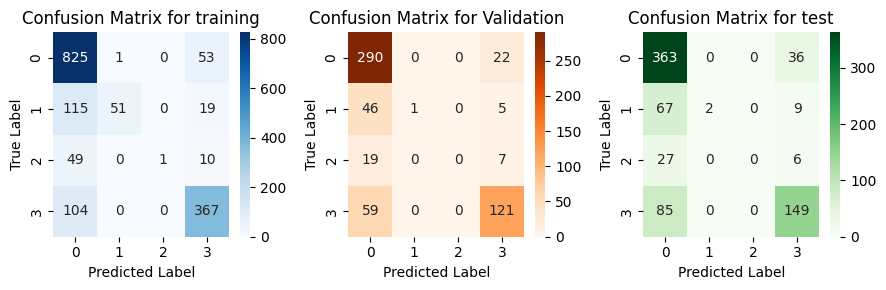

In [7]:
# defalut value:C=1.0, kernel='rbf', gamma='scale'
from sklearn.metrics import  f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def show_result():
  train_predictions = clf.predict(train_feature_vectors)
  valid_predictions = clf.predict(valid_feature_vectors)
  test_predictions = clf.predict(test_feature_vectors)

  train_accuracy = accuracy_score(labels['train'], train_predictions)
  valid_accuracy = accuracy_score(labels['valid'], valid_predictions)
  test_accuracy = accuracy_score(labels['test'], test_predictions)

  print(f"Training Accuracy: {train_accuracy * 100:.2f}%")
  print(f"Validation Accuracy: {valid_accuracy * 100:.2f}%")
  print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

  #  F1 score
  train_f1 = f1_score(labels['train'], train_predictions, average='weighted')
  valid_f1 = f1_score(labels['valid'], valid_predictions, average='weighted')
  test_f1 = f1_score(labels['test'], test_predictions, average='weighted')

  print(f"Training F1 Score: {train_f1:.2f}")
  print(f"Validation F1 Score: {valid_f1:.2f}")
  print(f"Test F1 Score: {test_f1:.2f}")

  #  confusion matrices
  train_cm = confusion_matrix(labels['train'], train_predictions)
  valid_cm = confusion_matrix(labels['valid'], valid_predictions)
  test_cm = confusion_matrix(labels['test'], test_predictions)

  plt.figure(figsize=(9, 3))

  #  Confusion Matrix for training
  plt.subplot(1, 3, 1)  # 1 row, 3 columns, 1st subplot
  sns.heatmap(train_cm, annot=True, fmt='g', cmap='Blues')
  plt.title('Confusion Matrix for training')
  plt.xlabel('Predicted Label')
  plt.ylabel('True Label')

  # Confusion Matrix for Validation
  plt.subplot(1, 3, 2)  # 1 row, 3 columns, 2nd subplot
  sns.heatmap(valid_cm, annot=True, fmt='g', cmap='Oranges')
  plt.title('Confusion Matrix for Validation')
  plt.xlabel('Predicted Label')
  plt.ylabel('True Label')

  # Confusion Matrix for test
  plt.subplot(1, 3, 3)  # 1 row, 3 columns, 3rd subplot
  sns.heatmap(test_cm, annot=True, fmt='g', cmap='Greens')
  plt.title('Confusion Matrix for test')
  plt.xlabel('Predicted Label')
  plt.ylabel('True Label')


  plt.tight_layout()
  plt.show()

clf = svm.SVC()
clf.fit(train_feature_vectors, labels['train'])
show_result()

Training Accuracy: 85.83%
Validation Accuracy: 74.04%
Test Accuracy: 70.97%
Training F1 Score: 0.85
Validation F1 Score: 0.71
Test F1 Score: 0.68


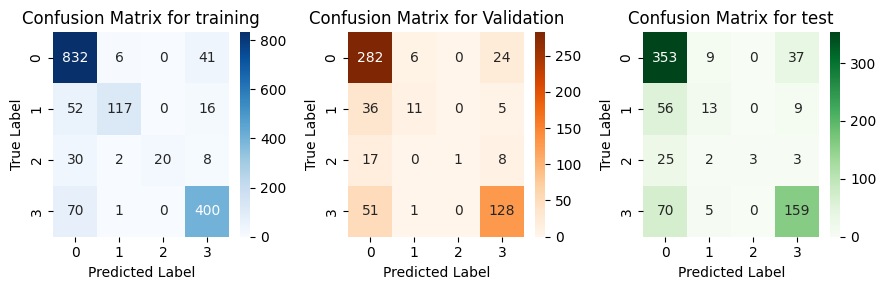

In [8]:
# C=2 which is the best value for C
clf = svm.SVC(C=2.0)
clf.fit(train_feature_vectors, labels['train'])

show_result()

Training Accuracy: 74.17%
Validation Accuracy: 67.89%
Test Accuracy: 62.23%
Training F1 Score: 0.73
Validation F1 Score: 0.66
Test F1 Score: 0.60


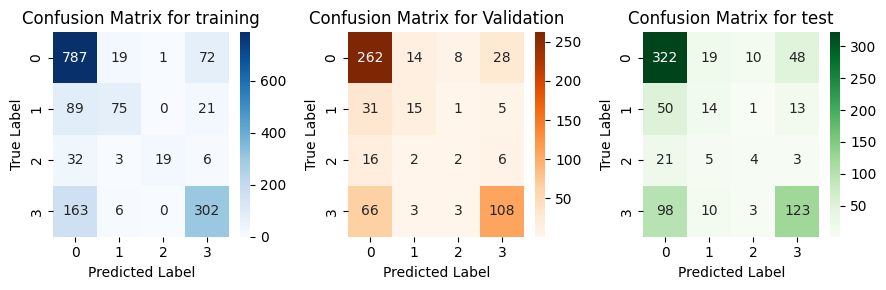

In [9]:
# linear svm
clf = svm.SVC(kernel='linear', C=1.0,gamma='scale')
clf.fit(train_feature_vectors, labels['train'])

show_result()

Training Accuracy: 71.41%
Validation Accuracy: 60.88%
Test Accuracy: 57.80%
Training F1 Score: 0.68
Validation F1 Score: 0.54
Test F1 Score: 0.49


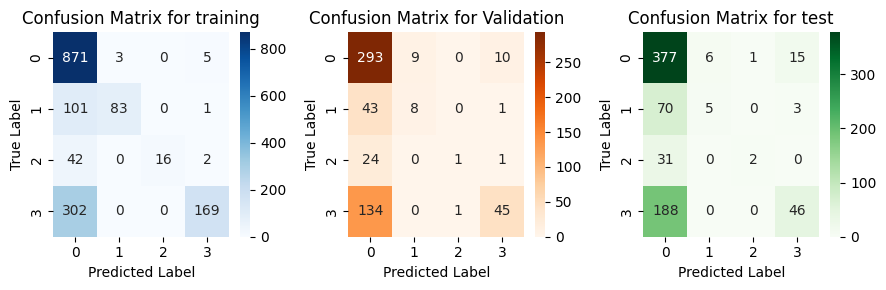

In [10]:
# poly svm
clf = svm.SVC(kernel='poly', C=1.0,gamma='scale')
clf.fit(train_feature_vectors, labels['train'])

show_result()

Training Accuracy: 59.87%
Validation Accuracy: 63.33%
Test Accuracy: 60.89%
Training F1 Score: 0.54
Validation F1 Score: 0.58
Test F1 Score: 0.55


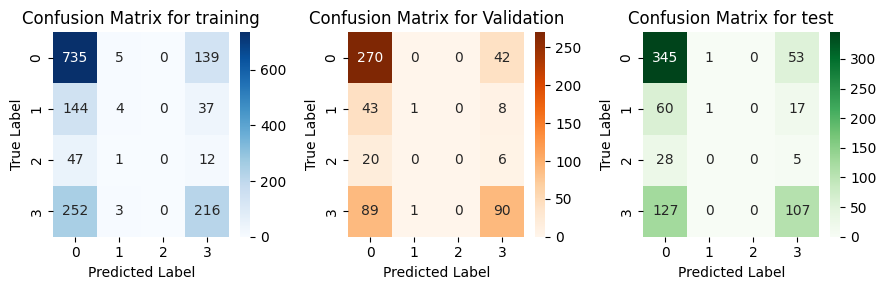

In [11]:
# sigmod svm
clf = svm.SVC(kernel='sigmoid', C=1.0,gamma='scale')
clf.fit(train_feature_vectors, labels['train'])

show_result()

For mono part 

In [12]:
data_path = 'mono' 
data, labels = load_dataset(data_path)

sift = cv2.SIFT_create()
def extract_sift_features(images):
    descriptors = []
    for image in images:
        kp, des = sift.detectAndCompute(image, None)
        if des is not None:
            descriptors.extend(des)
    return descriptors

train_descriptors = extract_sift_features(data['train'])

k = 120 
kmeans = KMeans(n_clusters=k, random_state=0)

train_descriptors_float32 = np.vstack([d.astype(np.float32) for d in train_descriptors])

kmeans.fit(train_descriptors_float32)

def images_to_feature_vectors(images, kmeans):
    feature_vectors = []
    for image in images:
        kp, des = sift.detectAndCompute(image, None)
        if des is not None:
            words = kmeans.predict(des)
            img_feature = np.bincount(words, minlength=kmeans.n_clusters)
            feature_vectors.append(img_feature)
        else:
            feature_vectors.append(np.zeros(kmeans.n_clusters))
    return feature_vectors

train_feature_vectors = images_to_feature_vectors(data['train'], kmeans)
valid_feature_vectors = images_to_feature_vectors(data['valid'], kmeans)
test_feature_vectors = images_to_feature_vectors(data['test'], kmeans)

scaler = StandardScaler().fit(train_feature_vectors)
train_feature_vectors = scaler.transform(train_feature_vectors)
valid_feature_vectors = scaler.transform(valid_feature_vectors)
test_feature_vectors = scaler.transform(test_feature_vectors)

/Users/lorraine.gao/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training Accuracy: 83.98%
Validation Accuracy: 77.87%
Test Accuracy: 72.82%
Training F1 Score: 0.82
Validation F1 Score: 0.74
Test F1 Score: 0.68


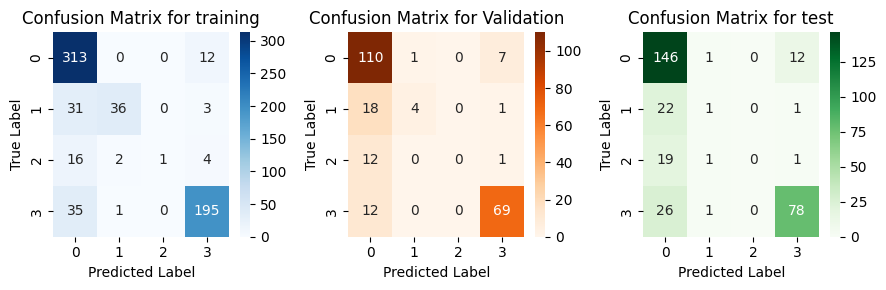

In [13]:
clf = svm.SVC()
clf.fit(train_feature_vectors, labels['train'])

show_result()


Training Accuracy: 90.91%
Validation Accuracy: 80.85%
Test Accuracy: 74.11%
Training F1 Score: 0.91
Validation F1 Score: 0.78
Test F1 Score: 0.70


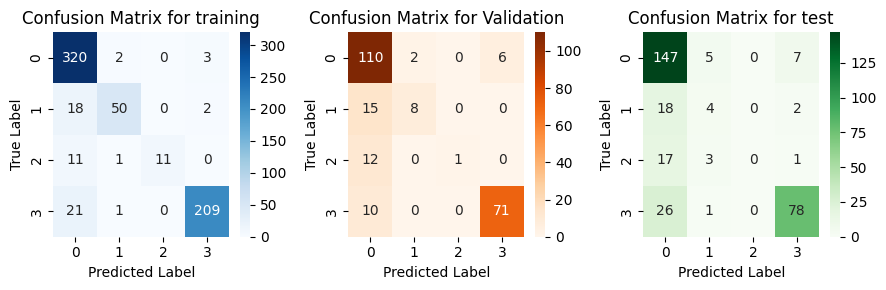

In [14]:
clf = svm.SVC(C=2.0)
clf.fit(train_feature_vectors, labels['train'])

show_result()

For poly part using SIFT

In [15]:
data_path = 'poly' 
data, labels = load_dataset(data_path)

sift = cv2.SIFT_create()
def extract_sift_features(images):
    descriptors = []
    for image in images:
        kp, des = sift.detectAndCompute(image, None)
        if des is not None:
            descriptors.extend(des)
    return descriptors

train_descriptors = extract_sift_features(data['train'])

k = 120 
kmeans = KMeans(n_clusters=k, random_state=0)

train_descriptors_float32 = np.vstack([d.astype(np.float32) for d in train_descriptors])

kmeans.fit(train_descriptors_float32)

def images_to_feature_vectors(images, kmeans):
    feature_vectors = []
    for image in images:
        kp, des = sift.detectAndCompute(image, None)
        if des is not None:
            words = kmeans.predict(des)
            img_feature = np.bincount(words, minlength=kmeans.n_clusters)
            feature_vectors.append(img_feature)
        else:
            feature_vectors.append(np.zeros(kmeans.n_clusters))
    return feature_vectors

train_feature_vectors = images_to_feature_vectors(data['train'], kmeans)
valid_feature_vectors = images_to_feature_vectors(data['valid'], kmeans)
test_feature_vectors = images_to_feature_vectors(data['test'], kmeans)

scaler = StandardScaler().fit(train_feature_vectors)
train_feature_vectors = scaler.transform(train_feature_vectors)
valid_feature_vectors = scaler.transform(valid_feature_vectors)
test_feature_vectors = scaler.transform(test_feature_vectors)

/Users/lorraine.gao/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training Accuracy: 82.25%
Validation Accuracy: 70.71%
Test Accuracy: 65.61%
Training F1 Score: 0.80
Validation F1 Score: 0.66
Test F1 Score: 0.60


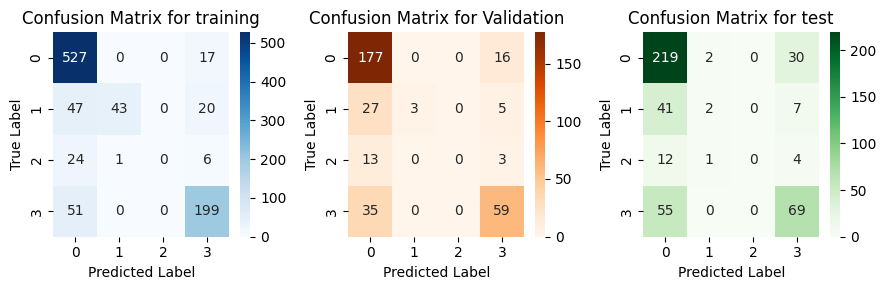

In [16]:
clf = svm.SVC()
clf.fit(train_feature_vectors, labels['train'])
show_result()

Training Accuracy: 92.19%
Validation Accuracy: 74.56%
Test Accuracy: 70.14%
Training F1 Score: 0.92
Validation F1 Score: 0.72
Test F1 Score: 0.68


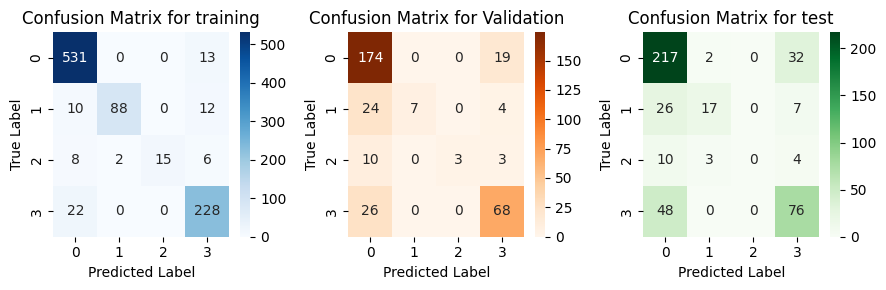

In [17]:
clf = svm.SVC(C=2.0)
clf.fit(train_feature_vectors, labels['train'])

show_result()

Using vgg model to extract features

In [18]:
import numpy as np
import os
from torchvision import models,transforms,datasets
from torch.utils.data import DataLoader

from sklearn import svm
from sklearn.metrics import f1_score, confusion_matrix
import torch
import torchvision.models as models
import numpy as np

overall_dataset = 'overall'
train_overall = os.path.join(overall_dataset,'train')
valid_overall = os.path.join(overall_dataset,'valid')
test_overall = os.path.join(overall_dataset,'test')
bs = 32
num_classes = len(os.listdir(train_overall))
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomRotation(degrees=90),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor()
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor()
    ])
}

data = {
    'train': datasets.ImageFolder(root=train_overall, transform=data_transforms['train']),
    'test': datasets.ImageFolder(root=test_overall, transform=data_transforms['test']),
    'valid': datasets.ImageFolder(root=valid_overall, transform=data_transforms['valid'])
}

idx_to_class = {v: k for k, v in data['train'].class_to_idx.items()}
classes_names = data['train'].classes

overall_train_loader = DataLoader(data['train'], batch_size=bs, shuffle=True)
overall_test_loader = DataLoader(data['test'], batch_size=bs, shuffle=True)
overall_valid_loader = DataLoader(data['valid'], batch_size=bs, shuffle=True)

/Users/lorraine.gao/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [19]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16 = models.vgg16_bn(pretrained = True)
vgg16 = vgg16.to(device)

/Users/lorraine.gao/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/lorraine.gao/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [20]:
def extract_features(loader, model):
    features_list = []
    labels_list = []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            features = model.features(inputs)  # Use VGG16's feature extractor
            features = torch.nn.functional.adaptive_avg_pool2d(features, (1, 1)).view(features.size(0), -1)
            features_list.append(features.cpu().numpy())
            labels_list.append(labels.cpu().numpy())

    features_array = np.concatenate(features_list, axis=0)
    labels_array = np.concatenate(labels_list, axis=0)

    features_array = features_array.reshape(features_array.shape[0], -1)
    return features_array, labels_array

# load pretrained model
vgg16.eval()
vgg16 = models.vgg16_bn(pretrained=True)
vgg16 = vgg16.to(device)
for param in vgg16.parameters():
    param.requires_grad = False 
    # we only need the feature extractor of VGG16 model,so after loading the pretrained model, 
    # set requires_grad of all model parameters to False, so that gradients will not be calculated and computing resources will be saved

train_features, train_labels = extract_features(overall_train_loader, vgg16)
valid_features, valid_labels = extract_features(overall_valid_loader, vgg16)
test_features, test_labels = extract_features(overall_test_loader, vgg16)

Training Accuracy: 76.24%
test Accuracy: 69.62%
Training F1 Score: 0.70
test F1 Score: 0.64


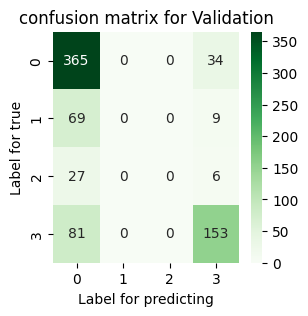

In [21]:
# c=1.0 by default, kernel=rbf
def showvggresult():
  train_predictions = clf.predict(train_features)
  test_predictions = clf.predict(test_features)

  train_accuracy = accuracy_score(train_labels, train_predictions)
  test_accuracy = accuracy_score(test_labels, test_predictions)

  print(f"Training Accuracy: {train_accuracy * 100:.2f}%")
  print(f"test Accuracy: {test_accuracy * 100:.2f}%")

  train_f1 = f1_score(train_labels, train_predictions, average='weighted')
  test_f1 = f1_score(test_labels, test_predictions, average='weighted')
  print(f"Training F1 Score: {train_f1:.2f}")
  print(f"test F1 Score: {test_f1:.2f}")

  import matplotlib.pyplot as plt
  import seaborn as sns
  test_cm = confusion_matrix(test_labels, test_predictions)
  plt.figure(figsize=(3,3))
  sns.heatmap(test_cm, annot=True, fmt='d', cmap="Greens")
  plt.title('confusion matrix for Validation')
  plt.xlabel('Label for predicting')
  plt.ylabel('Label for true')
  plt.show()

clf = svm.SVC(C=1.0,gamma='scale')
clf.fit(train_features, train_labels)
showvggresult()

Training Accuracy: 89.15%
test Accuracy: 67.07%
Training F1 Score: 0.88
test F1 Score: 0.61


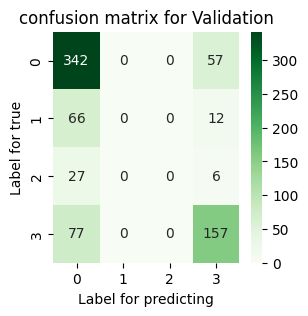

In [22]:
clf = svm.SVC(C=2.0,gamma='scale')
clf.fit(train_features, train_labels)
showvggresult()

In [23]:
# for separately mono
overall_dataset = 'mono'
train_overall = os.path.join(overall_dataset,'train')
valid_overall = os.path.join(overall_dataset,'valid')
test_overall = os.path.join(overall_dataset,'test')
bs = 32
num_classes = len(os.listdir(train_overall))
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomRotation(degrees=90),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor()
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor()
    ])
}

data = {
    'train': datasets.ImageFolder(root=train_overall, transform=data_transforms['train']),
    'test': datasets.ImageFolder(root=test_overall, transform=data_transforms['test']),
    'valid': datasets.ImageFolder(root=valid_overall, transform=data_transforms['valid'])
}

idx_to_class = {v: k for k, v in data['train'].class_to_idx.items()}
classes_names = data['train'].classes

mono_train_loader = DataLoader(data['train'], batch_size=bs, shuffle=True)
mono_test_loader = DataLoader(data['test'], batch_size=bs, shuffle=True)

In [24]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16 = models.vgg16_bn(pretrained = True)
vgg16 = vgg16.to(device)

/Users/lorraine.gao/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/lorraine.gao/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [25]:
vgg16.eval()
vgg16 = models.vgg16_bn(pretrained=True)
vgg16 = vgg16.to(device)
for param in vgg16.parameters():
    param.requires_grad = False 

train_features, train_labels = extract_features(mono_train_loader, vgg16)
test_features, test_labels = extract_features(mono_test_loader, vgg16)

Training Accuracy: 92.14%
test Accuracy: 67.64%
Training F1 Score: 0.92
test F1 Score: 0.62


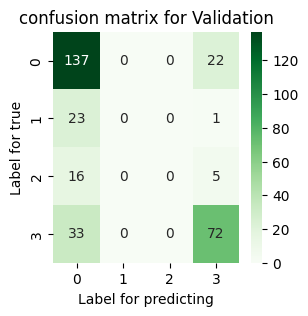

In [26]:
clf = svm.SVC(C=2.0,gamma='scale')
clf.fit(train_features, train_labels)
showvggresult()

In [27]:
# for separately poly
overall_dataset = 'poly'
train_overall = os.path.join(overall_dataset,'train')
valid_overall = os.path.join(overall_dataset,'valid')
test_overall = os.path.join(overall_dataset,'test')
bs = 32
num_classes = len(os.listdir(train_overall))

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomRotation(degrees=90),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor()
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor()
    ])
}

data = {
    'train': datasets.ImageFolder(root=train_overall, transform=data_transforms['train']),
    'test': datasets.ImageFolder(root=test_overall, transform=data_transforms['test']),
    'valid': datasets.ImageFolder(root=valid_overall, transform=data_transforms['valid'])
}

idx_to_class = {v: k for k, v in data['train'].class_to_idx.items()}
classes_names = data['train'].classes

poly_train_loader = DataLoader(data['train'], batch_size=bs, shuffle=True)
poly_test_loader = DataLoader(data['test'], batch_size=bs, shuffle=True)

In [28]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16 = models.vgg16_bn(pretrained = True)
vgg16 = vgg16.to(device)

vgg16.eval()
vgg16 = models.vgg16_bn(pretrained=True)
vgg16 = vgg16.to(device)
for param in vgg16.parameters():
    param.requires_grad = False

train_features, train_labels = extract_features(poly_train_loader, vgg16)
test_features, test_labels = extract_features(poly_test_loader, vgg16)

/Users/lorraine.gao/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/lorraine.gao/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Training Accuracy: 92.09%
test Accuracy: 62.90%
Training F1 Score: 0.92
test F1 Score: 0.58


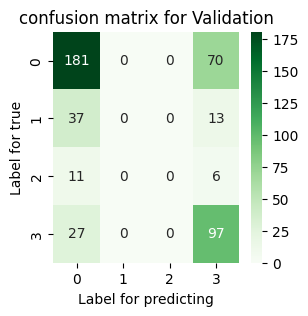

In [29]:
clf = svm.SVC(C=2.0,gamma='scale')
clf.fit(train_features, train_labels)
showvggresult()